In [1]:
import csv 
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
#sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
#sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis/Battery')
from battery import OCVcurve, Thevenin
import analog
from scipy.interpolate import interp1d as interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

### Import the equivalent circuit parameters

In [2]:
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R0 = 0.005
R1 = float(ECparams['R1'])
R1 = 0.01
C1 = float(ECparams['C1'])
C1 = 566.666

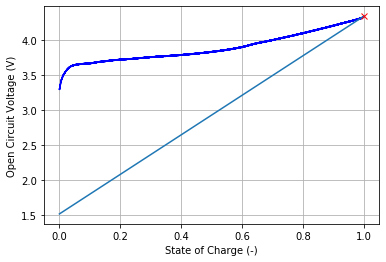

In [3]:
curve = OCVcurve('Battery 9/Discharge 200mA/SOCvsOCV_discharge200mA.csv')
curve.plot()
z0 = 1
a = curve.getslope(z0)
b = curve.OCVfromSOC(z0)-a*z0
x = np.array([0,1])
plt.plot(a*x+b)
plt.plot(z0,curve.OCVfromSOC(z0),'rx')

# Simulation

### Import the test file

In [4]:
folder = '/home/lucas/Documents/Log_Analysis/Logs/Snow Orange (Battery 9) z0=1'
#folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs'
log_file = analog.pathfromQGC(folder,index=195)

print(log_file)
info = analog.logextract(log_file,'battery_status')

current = info['battery_current']
time = info['time_bs']
voltage = info['battery_voltage']/4

/home/lucas/Documents/Log_Analysis/Logs/Snow Orange (Battery 9) z0=1/log_195_2019-9-26-14-05-18.ulg


### Tune some more simulation parameters

In [5]:
Q = 6230*3.6 # has to be in Coulombs
Q = 8000*3.6
eta = 1
z0 = curve.SOCfromOCV(np.mean(voltage[0])+R0*current[0]) # taken from log to be tested
print(f'z0 = {z0}')
battery = Thevenin(z0,Q,curve,R0,R1,C1)

z0 = 0.9844921997048863


In [6]:
print(f'True measured initital voltage is {voltage[0]:.2f} V')
print(f'True initial OCV would then be {voltage[0]+R0*current[0]:.2f} V, because initial current is {current[0]:.2f} A')

True measured initital voltage is 4.30 V
True initial OCV would then be 4.30 V, because initial current is 0.00 A


### Run the simulation using the state-space model

<IPython.core.display.Javascript object>


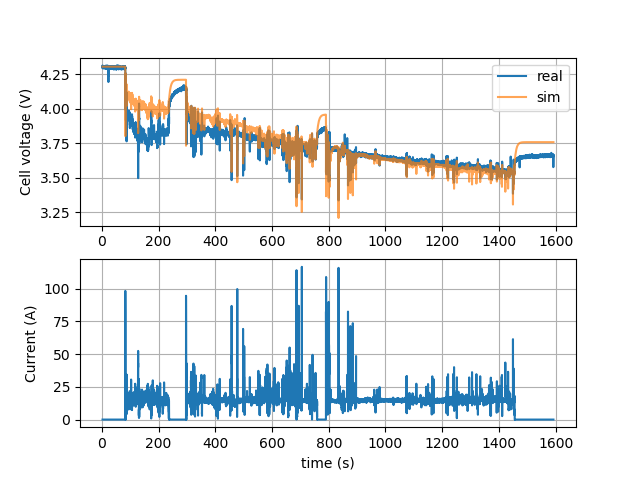

In [16]:
%matplotlib notebook
vsim = battery.simulate(time,current,plot=False)
battery.statespace(np.mean(np.diff(time)))
vlsim = battery.lsim(time,current,curve)

plt.figure()
plt.subplot(211)
plt.plot(time,voltage,label='real')
plt.plot(time,vsim,label='sim',alpha=.7)
#plt.plot(time,vlsim+3.6,label='linsim')
plt.legend()
plt.grid()
plt.ylabel('Cell voltage (V)')
plt.subplot(212)
plt.plot(time,current)
plt.xlabel('time (s)')
plt.ylabel('Current (A)')
plt.grid()
plt.show()

In [11]:
N = len(vsim)
rmserror = (1/N*np.sum((vsim-voltage)**2))**.5
print(f'Root mean square error is {round(rmserror*1000,2)} mV. It is acceptable under 10mV according to Prof. G.Plett.')

Root mean square error is 250.66 mV. It is acceptable under 10mV according to Prof. G.Plett.


In [12]:
n=20
R0list = np.array(np.linspace(0,15,n))*1e-3
R1list = np.array(np.linspace(0,15,n))*1e-3
C1list = np.array(np.linspace(100,1500,n))

sk = np.empty_like([],shape=[len(R0list),len(R1list),len(C1list)])
print(np.shape(sk))

batsim = Thevenin(z0,Q,curve,R0list[0],R1list[0],C1list[0])
print(z0)

(20, 20, 20)
0.9844921997048863


In [13]:
current_iteration = 0
max_iteration = n*n*n-1
for kr0 in range(len(R0list)):
    for kr in range(len(R1list)):
        for kc in range(len(C1list)):
            progress = current_iteration / max_iteration
            print(f'progress: {progress*100} % \r')
            current_iteration += 1
            batsim.reset(R0list[kr0],R1list[kr],C1list[kc],z0)
            vsim = batsim.simulate(time,current)
            rms = (np.mean((voltage-vsim)**2))**.5
            sk[kr0,kr,kc] = rms

progress: 0.0 % 
progress: 0.012501562695336917 % 
progress: 0.025003125390673835 % 
progress: 0.037504688086010755 % 
progress: 0.05000625078134767 % 


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


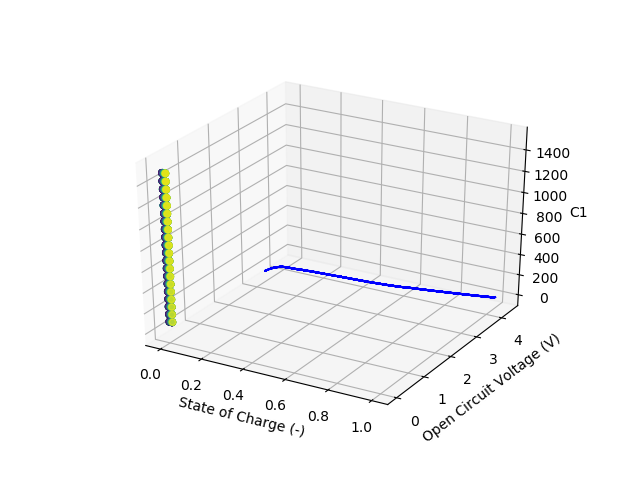

0.07833662329889819
(6, 11, 5)
0.07833662329889819
0.004736842105263157
0.008684210526315789
468.42105263157896


In [15]:
'''
==============
3D scatterplot
==============

Demonstration of a basic scatterplot in 3D.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
c = [i for i in range(0,99)]
m = 'o'
xs,ys,zs = np.meshgrid(R0list,R1list,C1list)
ax.scatter(xs, ys, zs, c=np.reshape(sk,(8000,)), marker=m)

ax.set_xlabel('R0')
ax.set_ylabel('R1')
ax.set_zlabel('C1')

plt.show()
print(np.min(sk))
print(np.unravel_index(np.argmin(sk),np.shape(sk)))
print(sk[6,11,5])
print(R0list[6])
print(R1list[11])
print(C1list[5])

<IPython.core.display.Javascript object>


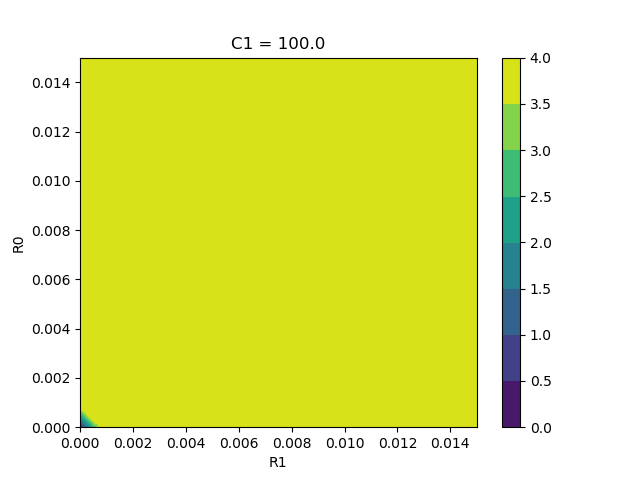

<IPython.core.display.Javascript object>


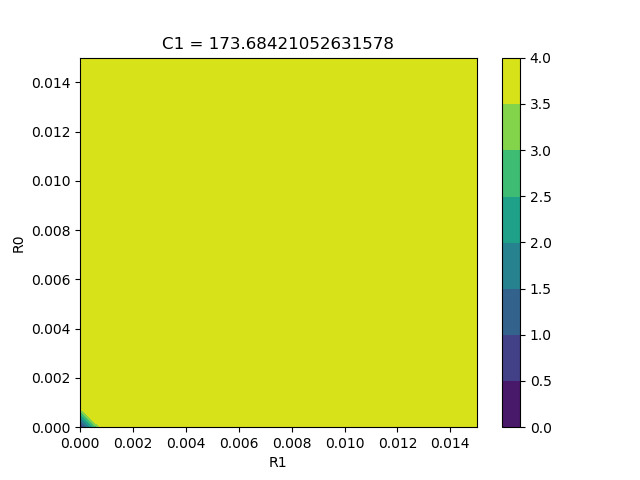

<IPython.core.display.Javascript object>


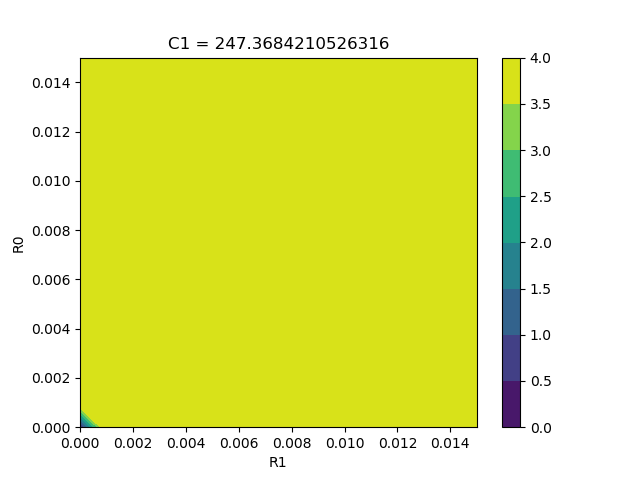

<IPython.core.display.Javascript object>


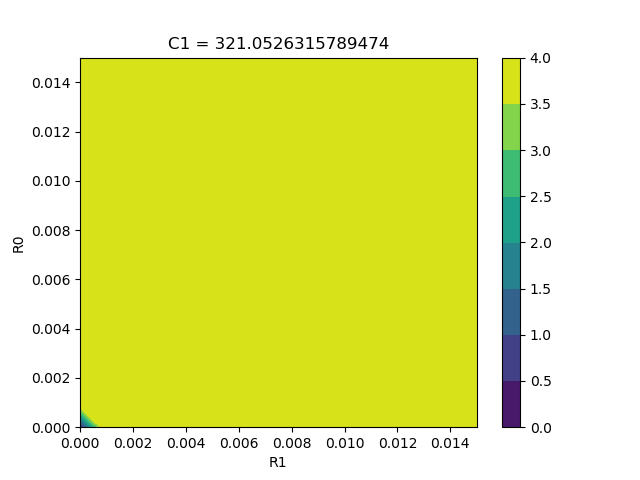

<IPython.core.display.Javascript object>


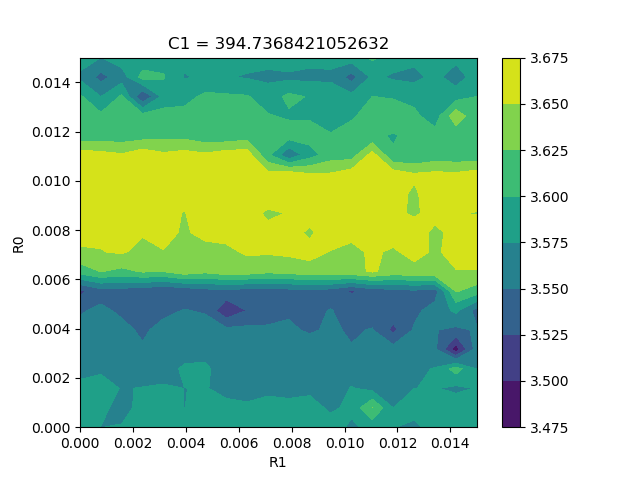

<IPython.core.display.Javascript object>


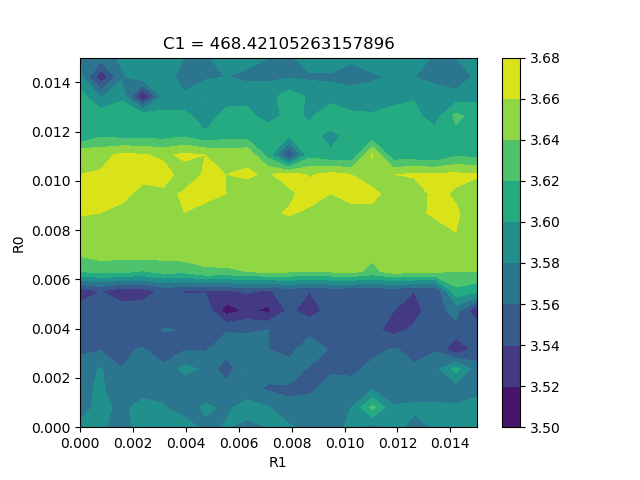

<IPython.core.display.Javascript object>


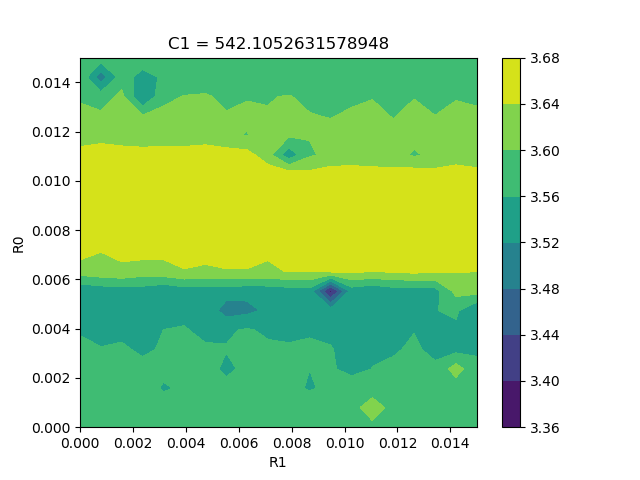

<IPython.core.display.Javascript object>


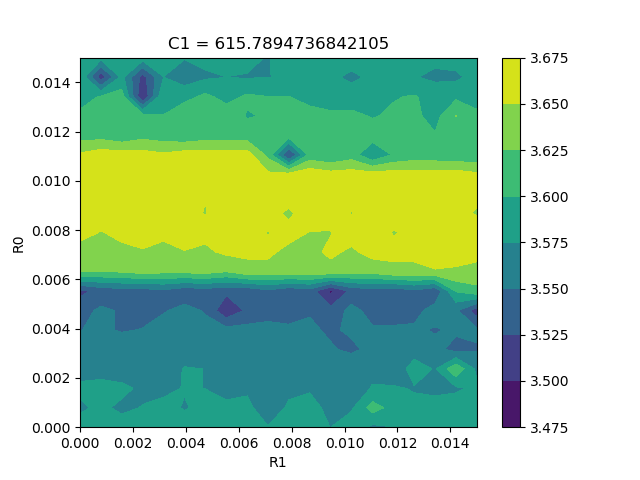

<IPython.core.display.Javascript object>


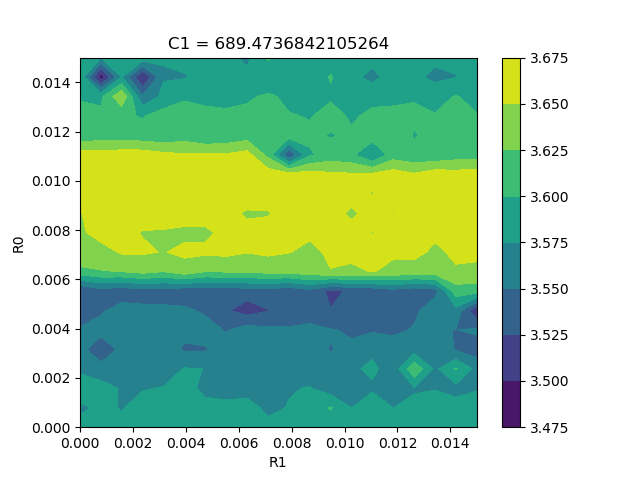

<IPython.core.display.Javascript object>


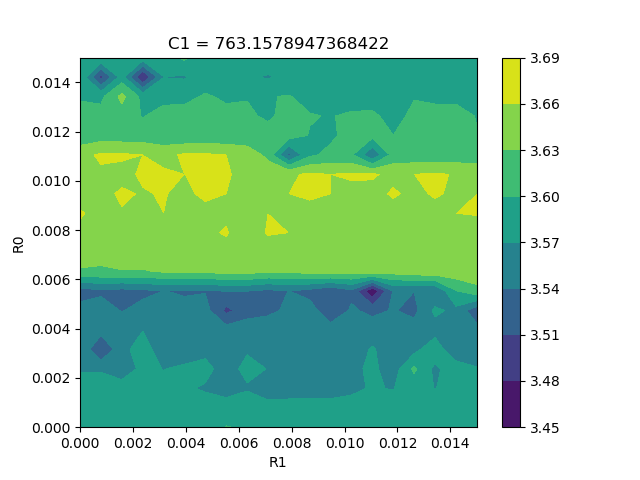

<IPython.core.display.Javascript object>


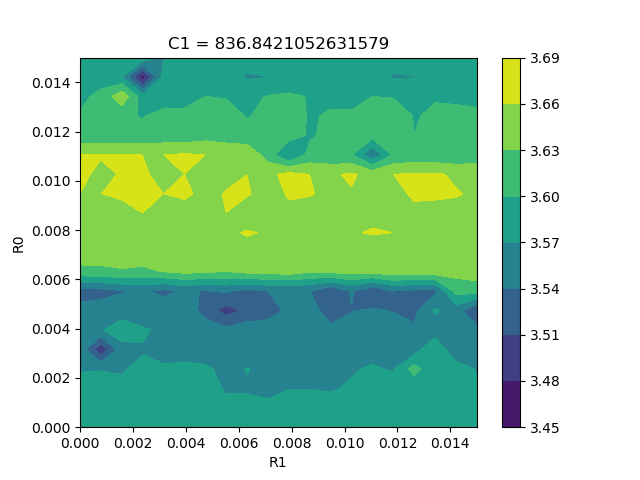

<IPython.core.display.Javascript object>


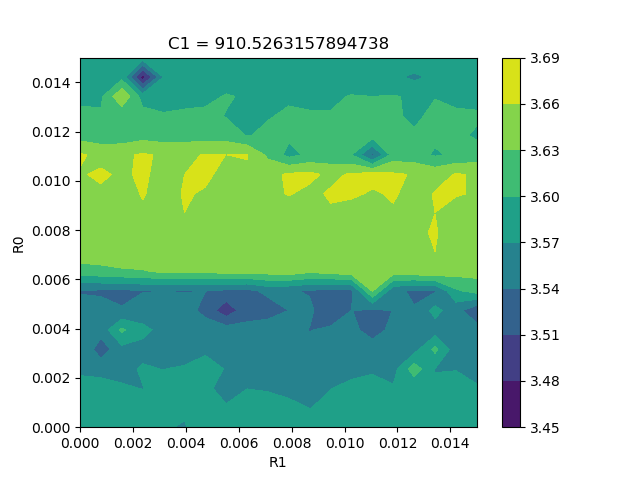

<IPython.core.display.Javascript object>


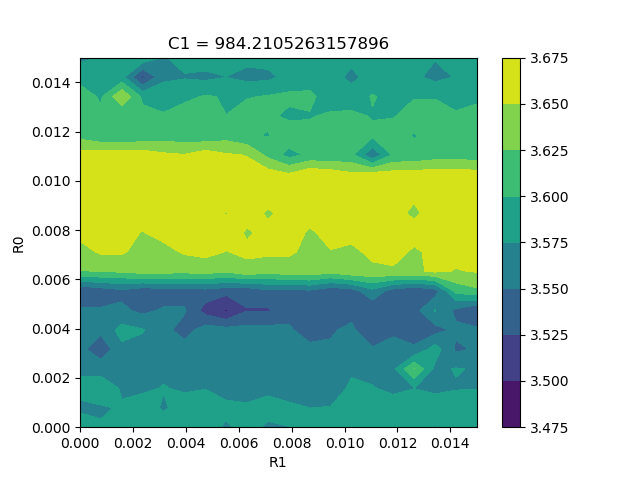

<IPython.core.display.Javascript object>


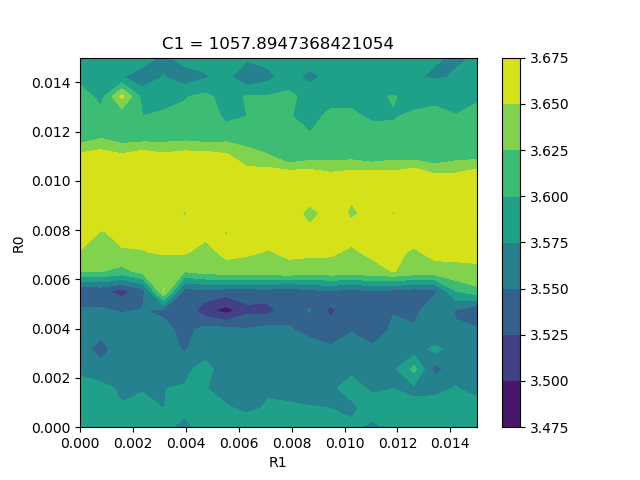

<IPython.core.display.Javascript object>


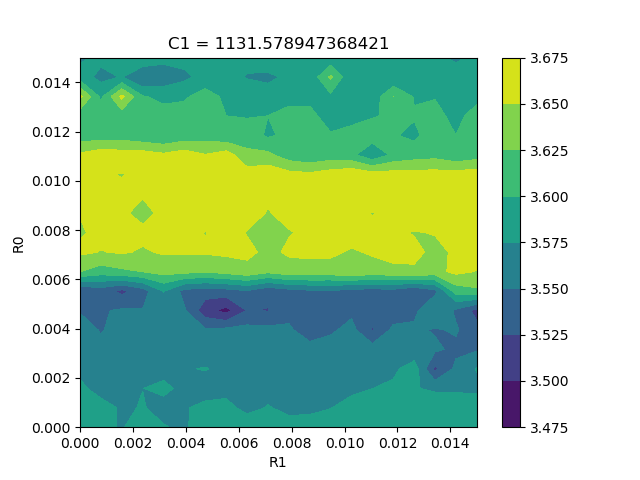

<IPython.core.display.Javascript object>


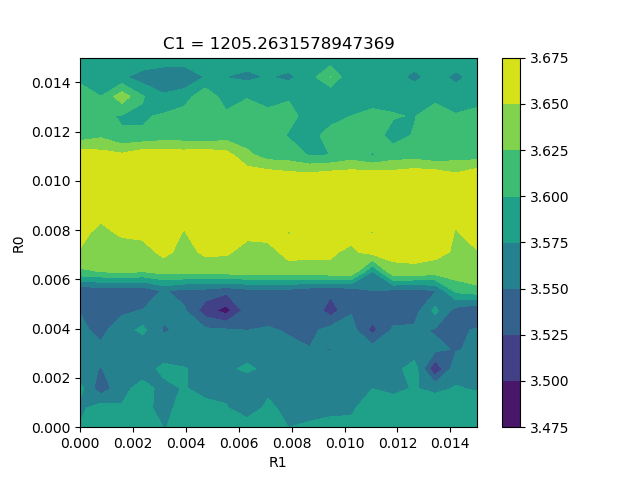

<IPython.core.display.Javascript object>


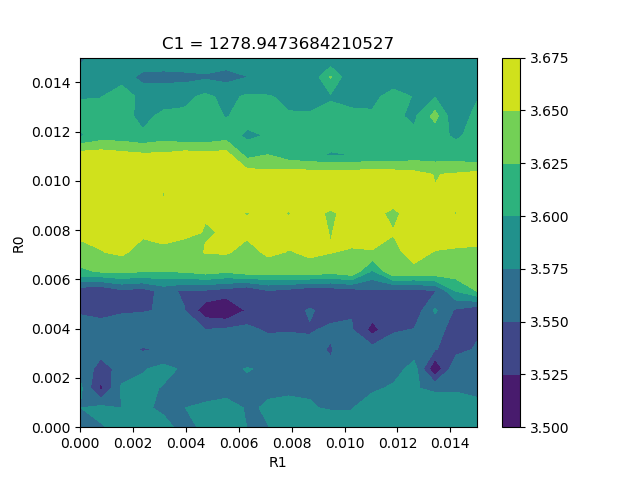

<IPython.core.display.Javascript object>


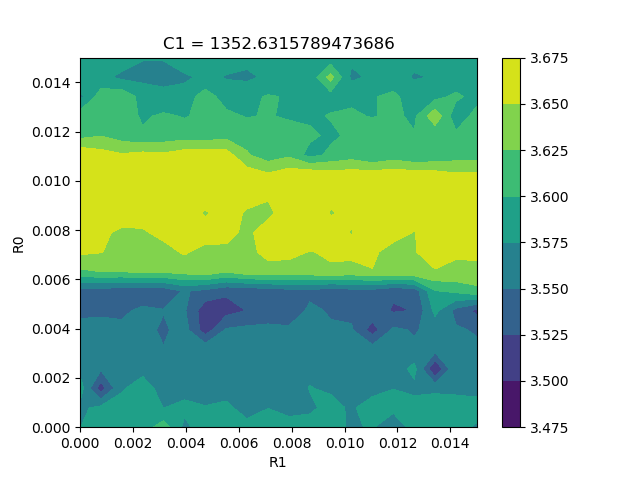

<IPython.core.display.Javascript object>


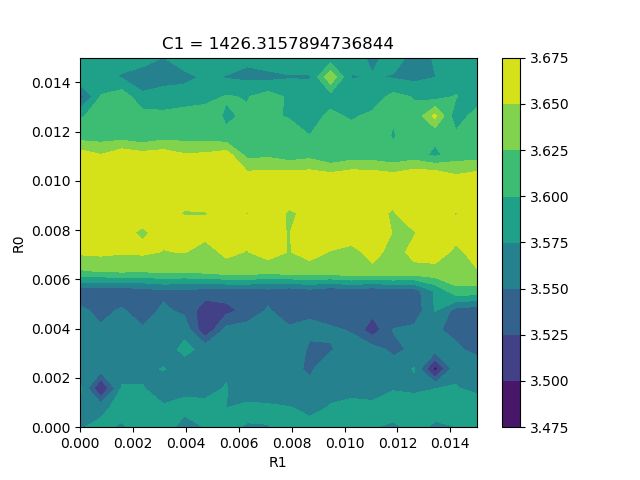

/home/lucas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


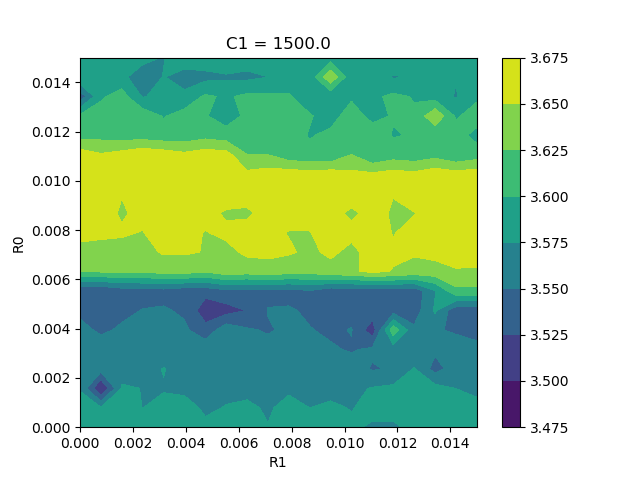

In [14]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm 

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

for kc in range(len(C1list)):
    plt.figure()
    plt.contourf(R1list,R0list,sk[:,:,kc])
    plt.colorbar()
    plt.xlabel('R1')
    plt.ylabel('R0')
    plt.title(f'C1 = {C1list[kc]}')

/home/lucas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


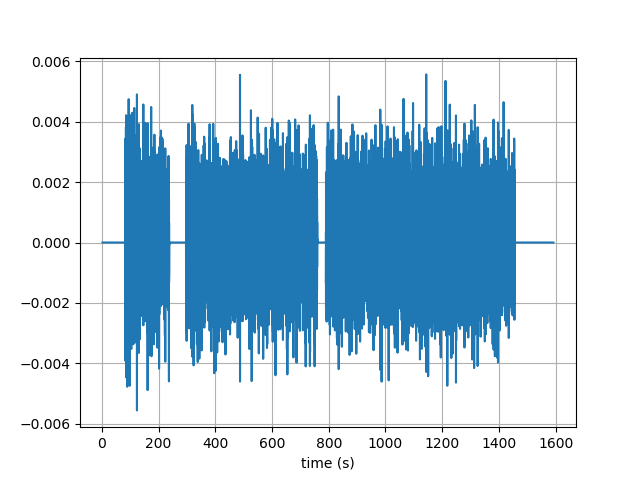

In [15]:
vtilda = vsim - curve.OCVfromSOC(battery.simz[1:])

plt.figure()
plt.plot(time,vtilda)
plt.xlabel('time (s)')
# plt.ylabel('v_{load}-OCV', usetex=True)
plt.grid()
plt.show()

# Kalman Filter

In [ ]:
import filterpy
from filterpy.kalman import KalmanFilter

In [ ]:
dim_x = 2 # number of states
dim_z = 1 # number of outputs
kf = KalmanFilter(2,1)
battery.statespace(battery.simdt)
kf.F = battery.A 
kf.B = battery.B 

In [ ]:
xplus0 = np.array([[z0],[0.]]) # is a stack of 2x1 arrays = a 2xk array
covxplus0 = np.array([[1e-4,0.],[0., .1]]) # is a stack of 2x2 arrays

covw = np.array([[0.05, 0.],[0., 0.]]) # is a constant 2x2 array
covv = 0.5017 # is a constant 1x1 array

xminus = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covmxminus = np.array([]) # is a stack of 2x2 arrays
yhat = np.array([]) # is a stack of 1x1 arrays = a 1-D array
xplus = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covxplus = np.array([]) # is a stack of 2x2 arrays
covxy = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covy = np.array([]) # is a stack of 1x1 arrays = a 1-D array
L = np.array([]) # is a stack of stack of 2x1 arrays = a 1-D array

u = current # is a stack of 1x1 arrays = a 1-D array
y = voltage # is a stack of 1x1 arrays = a 1-D array

kfbat = Thevenin(z0,Q,curve,R0,R1,C1)

In [ ]:
n = 10
for k in range(len(y[:n+1])):
    #print(f'\n New iteration k={k}')
    
    #if k==0:
        #print(f'Real value of z : {battery.simz[k]}, a posteriori estimated value of z : {xplus0[0]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a posteriori estimated value of i1 : {xplus0[1]}')
    #else:
        #print(f'Real value of z : {battery.simz[k]}, a posteriori estimated value of z : {xplus[0,-1]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a posteriori estimated value of i1 : {xplus[1,-1]}')
    
    if k == 0: 
        kfbat.reset(R0,R1,C1,xplus0[0])
    else: 
        kfbat.reset(R0,R1,C1,xplus[0,-1])
    kfbat.statespace(battery.simdt)
    
    
    #print(f'Matrix C is {kfbat.C}')
    
    
    # 1 : Prediction update
    
    # 1a State prediction
    
    if k==0: 
        alpha = np.reshape(kfbat.A@xplus0,(2,1))
        xminus = alpha
    
    else : 
        alpha = np.reshape(kfbat.A@xplus[:,k-1],(2,1))
        beta = kfbat.B*u[k-1]
        xminus = np.concatenate([xminus, alpha + beta],axis=1)
    
    
    #if k==0:
        #print(f'Real value of z : {battery.simz[k]}, a priori estimated value of z : {xplus0[0]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a priori estimated value of i1 : {xplus0[1]}')
    #else:
        #print(f'Real value of z : {battery.simz[k]}, a priori estimated value of z : {xplus[0,-1]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a priori estimated value of i1 : {xplus[1,-1]}')
    
    
    #print(f'xminus is {np.shape(xminus)}, should be 2x{k+1}')
    
    kfbat.reset(R0,R1,C1,xminus[0,-1])
    kfbat.statespace(battery.simdt)
    
    
    # 1b State covariance a priori
    
    if k==0 :
        covxminus = kfbat.A@covxplus0@kfbat.A.T + covw
    elif k==1: 
        covxminus = np.dstack([covxminus,kfbat.A@covxplus@kfbat.A.T + covw])
    else :
        covxminus = np.dstack([covxminus,kfbat.A@covxplus[:,:,-1]@kfbat.A.T + covw])
    #print(f'covxminus = {covxminus}')    
    #print(f'covxminus is {np.shape(covxminus)}, should be 2x2x{k+1}')
    
    # 1c : Output predicition
    
    if k==0: 
        yhat = kfbat.OCVcurve.OCVfromSOC(xminus[0,k]) - R1*xminus[1,k] + kfbat.D*u[k]
    else : 
        yhat = np.concatenate([yhat,kfbat.OCVcurve.OCVfromSOC(xminus[0,k]) - R1*xminus[1,k] + kfbat.D*u[k]]) 
    #print(f'y : {y[k]}')  
    #print(f'yhat : {yhat[k]}')
    #print(f'yhat is {np.shape(yhat)}, should be {k+1}')
    
    # 2 : Measurement update
    
    # 2a Kalman gain computation
    
    if k==0:
        covxy = np.reshape(covxminus@kfbat.C.T,(2,1))
        covy = np.reshape(kfbat.C@covxminus@kfbat.C.T + covv,1)
        L = covxy/covy
    else : 
        covxy = np.concatenate([covxy,np.reshape(covxminus[:,:,k]@kfbat.C.T,(2,1))],axis=1)
        #print(f'covxy is {np.shape(covxy)}, should be {2,k+1}')
        #print(np.shape(kfbat.C@covxminus[:,:,k]@kfbat.C.T + covv))
        covy = np.concatenate([covy,np.reshape(kfbat.C@covxminus[:,:,k]@kfbat.C.T + covv,1)])
        L = np.concatenate([L,covxy/covy],axis=1)
    #print(f'covy is {np.shape(covy)}, should be {k+1}')
    
    #print(f'covxy = {covxy[:,k]}')      
    #print(f'Lk={np.reshape(L[:,-1],(2,1))}')
    
    #print(f'L is {np.shape(L)}, should be 2x{k+1}')
          
    # 2b State estimate correction
          
    inno = y[k] - yhat[k]
    #print(f'Innovation : {inno}')
    
    if k==0:
        xplus = xplus0  
    else : 
        xplus = np.concatenate([xplus,np.reshape(xminus[:,k],(2,1)) + np.reshape(L[:,k]*inno,(2,1))],axis=1) 
    #print(f'xplus is {np.shape(xplus)}, should be 2x{k+1}')
    
    # 2c State covariance a posteriori 
    if k==0: 
          covxplus = covxminus - L*kfbat.C@covxminus
    else :
        covxplus = np.dstack([covxplus,covxminus[:,:,k] - L[:,k]*kfbat.C@covxminus[:,:,-1]])
        #print(covxplus[:,:,k])
    #print(f'covxplus is {np.shape(covxplus)}, should be 2x2x{k+1}')    
    

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure()
plt.subplot(311)
plt.plot(battery.simz[:n+1],'.-')
plt.plot(xminus[0,:],linestyle='-.')
plt.plot(xminus[0,:]+covxminus[0,0,:],color=colors[1],linewidth=0.7)
plt.plot(xminus[0,:]-covxminus[0,0,:],color=colors[1],linewidth=0.7)
#plt.plot(xplus[0,:],'.-')
plt.ylabel('state of charge')
plt.grid()
plt.subplot(312)
plt.plot(battery.simi1[:n+1],'.-',label='sim')
plt.plot(xplus[1,:],'-.',color = colors[1],label='KF')
plt.plot(xplus[1,:]+covxplus[1,1,:],color=colors[1],linewidth=0.7)
plt.plot(xplus[1,:]-covxplus[1,1,:],color=colors[1],linewidth=0.7)
plt.legend()
plt.ylabel('current through R1')
plt.grid()
plt.subplot(313)
plt.plot(battery.simv[:n+1],'.-',label='sim')
plt.plot(yhat,'-.')
plt.plot(yhat+covy,color=colors[1],linewidth=0.7)
plt.plot(yhat-covy,color=colors[1],linewidth=0.7)
plt.xlabel('iterations')
plt.ylabel('terminal voltage')
plt.grid()

In [ ]:
norm_covxminus = []
norm_covxplus = []
for k in range(np.shape(covxminus)[2]):
    norm_covxminus.append(np.linalg.eig(covxminus[:,:,k])[0])
    norm_covxplus.append(np.linalg.eig(covxplus[:,:,k])[0])    

In [ ]:
plt.figure()
plt.subplot(311)
plt.plot(norm_covxminus,':',label='covxminus')
plt.plot(norm_covxplus,label='covxplus',alpha=0.7)
plt.legend()
plt.grid()
plt.subplot(312)
plt.plot(covy,label='covy')
plt.legend()
plt.grid()
plt.subplot(313)
plt.plot(covxy[0,:],label='cov(z,y)')
plt.plot(covxy[1,:],label='cov(i1,y)')
plt.legend()
plt.grid()
plt.show()

The second eigenvalue of covx does not change with the meausrement update, while the first one remains almost constant, even if systematically downed by 0.9 by the meausrement update.

In [ ]:
battery.kfinit()
plt.figure()
plt.plot(voltage)
plt.grid()
for k in range(len(current)):
    battery.kfupdate(current[k],voltage[k])
    plt.plot(k,battery.yhat,'r.',markersize=.4)
    #print(battery.yhat)


In [ ]:
battery.kfinit()
plt.figure()
plt.grid()
for k in range(len(current)):
    battery.kfupdate(current[k],vsim[k])
    plt.plot(k,battery.xhat[0],'r.',markersize=.4)
    #print(battery.yhat)
